In [8]:
!pip install --user apache-log-parser urlib

  Could not find a version that satisfies the requirement urlib (from versions: )
No matching distribution found for urlib
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
import apache_log_parser
from pprint import pprint
from collections import defaultdict

ips = {}

def geoip(ip):
    import json
    from  urllib.request import urlopen
    
    if not ip in ips:
        url = ('http://ipinfo.io/%s/json' % ip)
        print('getting from url %s' % url)
        response = urlopen(url)
        ips[ip] = json.load(response)

    return ips[ip]

def most_common(lst):
    return max(set(lst), key=lst.count)

line_parser = apache_log_parser.make_parser("%v %h %l %u %t \"%r\" %>s %b")
users = defaultdict(dict)
with open("alllogs.log", 'r', encoding='utf-8') as infile:
    for line in infile:
        l=line_parser(line)
        if (
            l['request_url'] is not None and
            l['request_url'].startswith('/simrob') and
            l['request_method'] == 'POST'
        ):
            accesstoken=l['request_url'].replace('/simrob/','').replace('/webhook','')
            u = users[accesstoken]
            u['id'] = accesstoken
            if not 'count' in u:
                u['count'] = 0
            if not 'count_webhook' in u:
                u['count_webhook'] = 0
            if not 'count_query' in u:
                u['count_query'] = 0
            if not 'access_times' in u:
                u['access_times'] = []
            if not 'remote_host' in u:
                u['remote_host'] = []
            u['remote_host'].append(l['remote_host'])

            u['access_times'].append(l['time_received_datetimeobj'])
            u['count'] += 1
            if l['request_url'].endswith('/webhook'):
                u['count_webhook'] += 1
            else:
                u['count_query'] += 1
            
    #pprint(l)
    for u in users:
        users[u]['first_access'] = min(users[u]['access_times'])
        users[u]['last_access'] = max(users[u]['access_times'])
        users[u]['most_common_remote_host'] = most_common(users[u]['remote_host'])
        users[u]['most_common_geoip'] = geoip(users[u]['most_common_remote_host'])
        users[u]['access_span_hours'] = (
            users[u]['last_access'] - users[u]['first_access']
        ).total_seconds() / (3600.0)
        del users[u]['access_times']
        del users[u]['remote_host']
        pprint(users[u])

getting from url http://ipinfo.io/157.88.207.205/json
{'access_span_hours': 22.92972222222222,
 'count': 314,
 'count_query': 248,
 'count_webhook': 66,
 'first_access': datetime.datetime(2018, 6, 12, 21, 7, 24),
 'id': '5c66d843be1f4675b80bfd65dcc9e6b4',
 'last_access': datetime.datetime(2018, 6, 13, 20, 3, 11),
 'most_common_geoip': {'city': 'Valladolid',
                       'country': 'ES',
                       'hostname': 'as3-05.simula.eis.uva.es',
                       'ip': '157.88.207.205',
                       'loc': '41.6552,-4.7237',
                       'org': 'AS766 Entidad Publica Empresarial Red.es',
                       'postal': '47001',
                       'region': 'Castille and León'},
 'most_common_remote_host': '157.88.207.205'}
getting from url http://ipinfo.io/157.88.207.216/json
{'access_span_hours': 1.3155555555555556,
 'count': 174,
 'count_query': 127,
 'count_webhook': 47,
 'first_access': datetime.datetime(2018, 6, 13, 17, 2, 49),
 'id': 'c0

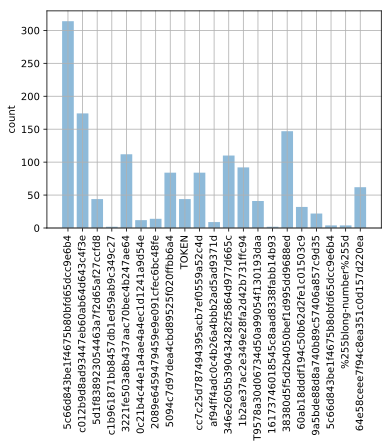

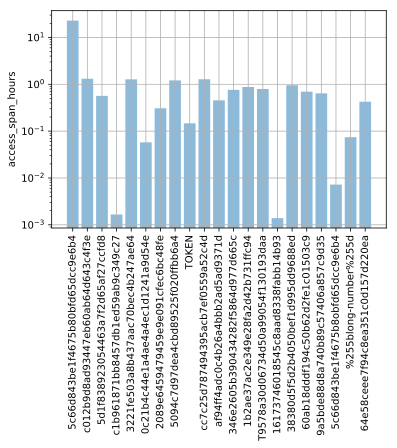

In [17]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg'] # ,'png', 'pdf'

import matplotlib.pyplot as plt
x_pos = list(range(len(users)))
y_pos = [users[u]['count'] for u in users]
plt.bar(x_pos, y_pos, align='center', alpha=0.5)
plt.grid()

# set height of the y-axis

# set axes labels and title
plt.ylabel('count')
plt.xticks(x_pos, users.keys(), rotation='vertical')

plt.show()
###
y_pos = [users[u]['access_span_hours'] for u in users]
plt.bar(x_pos, y_pos, align='center', alpha=0.5)
plt.yscale('log')

plt.grid()

# set height of the y-axis

# set axes labels and title
plt.ylabel('access_span_hours')
plt.xticks(x_pos, users.keys(), rotation='vertical')

plt.show()



In [40]:
#!pip install -U --user folium pandas
import folium
folium_map = folium.Map(location=[0,0],
                        zoom_start=2,
                        tiles="Stamen Terrain")
for u in users:
    l = users[u]['most_common_geoip']
    loc = [float(p) for p in l['loc'].split(',')]
    #print(loc)

    marker = folium.CircleMarker(
        location=loc, radius=5, fill=True,
        popup = u
    )
    marker.add_to(folium_map)


In [41]:
folium_map